In [1]:
# for QR codes use inline
%matplotlib inline
qr_setting = 'url'
#
# for lecture use notebook
# %matplotlib notebook
# qr_setting = None
#
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import laUtilities as ut
import slideUtilities as sl
import demoUtilities as dm
import pandas as pd
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML;

# Matrix Factorizations

Just as muiltiplication can be generalized from scalars to matrices, the notion of a factorization can also be generalized from scalars to matrices.

A _factorization_ of a matrix $A$ is an equation that expresses $A$ as a product of two or more matrices.  

$$A = BC.$$

The essential difference with what we have done so far is that we have been given factors ($B$ and $C$) and then computed $A$.  

In a factorization problem, you are given $A$, and you want to find $B$ and $C$ -- that meet some conditions.

There are a number of reasons one may want to factor a matrix.

* Recasting $A$ into a form that makes computing with $A$ faster.
* Recasting $A$ into a form that makes working with $A$ easier.
* Recasting $A$ into a form that exposes important properties of $A$.

Today we'll work with one particular factorization that addesses the first case.   Later one we'll study factorizations that address the other two cases.

The factorization we will study is called the __LU Factorization.__  It is worth studying in its own right, and because it introduces the idea of factorizations, which we will study again later on.

## A Rationale for the LU Factorization

Consider the following problem.  You are given $A \in \mathbb{R}^{n\times n}$ and $B \in \mathbb{R}^{n\times p}$. 

You seek $X \in \mathbb{R}^{n\times p}$ such that:

$$ AX = B. $$

In other words, instead of the usual $A\mathbf{x} = \mathbf{b}$, now $X$ and $B$ are matrices.

By the rules of matrix multiplication, we can break this problem up.

Let $X = [\mathbf{x_1} \mathbf{x_2} \dots \mathbf{x_p}],$ and $B = [\mathbf{b_1} \mathbf{b_2} \dots \mathbf{b_p}]$.

Then:

$$A{\bf x_1} = {\bf b_1}$$
$$A{\bf x_2} = {\bf b_2}$$
$$\dots$$
$$A{\bf x_p} = {\bf b_p}$$

In other words, there are $p$ linear systems to solve.

Each linear system is conceptually a separate problem.

Note however that every linear system has the __same $A$ matrix.__

Naturally, you could solve these systems by first computing $A^{-1}$ and then computing:

$${\bf x_1} = A^{-1}{\bf b_1}$$
$${\bf x_2} = A^{-1}{\bf b_2}$$
$$\dots$$
$${\bf x_p} = A^{-1}{\bf b_p}$$

Or, more concisely:

$$ X = A^{-1}B $$

What is the computational cost of using the matrix inverse to solve $AX = B$?   

As [discussed earlier](L10MatrixInverse.html#matrices-larger-than-2-times-2) the operation count of matrix inversion is  $\sim 2n^3$ flops 

... that is, three times as many as Gaussian Elimination.

This cost will dominate the process.

Alternatively, we could perform Gaussian Elimination on each of the separate systems.  

This is probably worse, because [then we have to perform $\sim p \cdot \frac{2}{3}n^3$ flops.](L03RowReductions.html#the-cost-of-gaussian-elimination)  

Assuming $p > 3$, using Gaussian Elimination on each system means doing more work than if we invert $A$.

What if we could solve all these systems while performing Gaussian Elimination only __once?__ 

That would be a win, as it would cut our running time by a factor of 3 compared to using the matrix inverse.

The LU factorization allows us to do exactly this.

Today we will explore the LU factorization.   We will see that LU factorization has a close connection to Gaussian Elimination.

In fact, I hope that when we are done, you will see Gaussian Elimination in a new way, namely:
    
> __Gaussian Elimination is really a matrix factorization!__

Before we start to discuss the LU factorization, we need to introduce a powerful tool for performing factorizations, called _elementary matrices._

## Elementary Matrices

Recall from the first and second lectures that the row reduction process consists of repeated applications of elementary row operations:

* Exchange two rows
* Multiply a row by a constant
* Add a multiple of one row to another

Now that we have much more theoretical machinery in our toolbox, we can make an important observation:

__Every elementary row operation on $A$ can be performed by multiplying $A$ by a suitable matrix.__

That is, an elementary row operation is a linear transformation!  

Furthermore, the matrices that implement elementary row operations are particularly simple.  They are called __elementary matrices.__

An elementary matrix is one that is obtained by __performing a single elementary row operation on the identity matrix.__

__Example.__  Let

$$E_1 = \left[\begin{array}{rrr}1&0&0\\0&1&0\\-4&0&1\end{array}\right],\;\; E_2 = \left[\begin{array}{rrr}0&1&0\\1&0&0\\0&0&1\end{array}\right],\;\; E_3 = \left[\begin{array}{rrr}1&0&0\\0&1&0\\0&0&5\end{array}\right].$$

Let's see what each matrix does to an arbitrary matrix $A = \left[\begin{array}{rrr}a&b&c\\d&e&f\\g&h&i\end{array}\right].$

$$ E_1A = \left[\begin{array}{rrr}a&b&c\\d&e&f\\g-4a&h-4b&i-4c\end{array}\right]. $$

$$ E_2A = \left[\begin{array}{rrr}d&e&f\\a&b&c\\g&h&i\end{array}\right].$$

$$ E_3A = \left[\begin{array}{rrr}a&b&c\\d&e&f\\5g&5h&5i\end{array}\right].$$

Clearly, left-multiplication by $E_1$ will add -4 times row 1 to row 3 (for any matrix $A$).

### Finding the Elementary Matrix

In fact, you can look at this as follows.  

Assume that some matrix $E$ exists that implements the operation "add -4 times row 1 to row 3."  

Now, for any matrix, $EI = E$ by the definition of $I$.  

But note that this equation also says:

"the matrix ($E$) that implements the operation 'add -4 times row 1 to row 3' is the one you get by performing this operation on $I$"

Thus we have the following:

__Fact.__ If an elementary row operation is performed on an $m\times n$ matrix $A,$ the resulting matrix can be written as $EA$, where the $m\times m$ matrix $E$ is created by performing the same row operation on $I_m$.

This is actually a special case of a general rule we already know: 

> to compute the standard matrix of a linear transformation, ask what that transformation does to the identity matrix.

One more thing: is an elementary matrix invertible?   

Clearly, __yes:__ any row reduction operation can be reversed by another (related) row reduction operation.   

So every row reduction is an invertible linear transformation -- so __every elementary matrix is invertible.__

``` {toggle}
Question Time! Q12.1
```

## The LU Factorization

Now, we will introduce the factorization 

$$ A = LU.$$

Note that we don't need to consider only square matrices $A$.  

LU decomposition (like Gaussian Elimination) works for a matrix $A$ having any shape.

An LU factorization of $A$ constructs two matrices that have this structure:

$$A = \begin{array}{cc}
\left[\begin{array}{cccc}1&0&0&0\\ *&1&0&0\\ *&*&1&0\\ *&*&*&1\end{array}\right]&
\left[\begin{array}{ccccc}\blacksquare&*&*&*&*\\0&\blacksquare&*&*&*\\0&0&0&\blacksquare&*\\0&0&0&0&0\end{array}\right]\\
L&U\\
\end{array}
$$

Stars ($*$) denote arbitrary entries, and blocks ($\blacksquare$) denote nonzero entries.

These two matrices each have a special structure.

First of all, $U$ is in row echelon form, and it has the same shape as $A$.   This is the "upper" matrix (hence its name $U$).

Second, $L$ is a lower triangular square matrix, and it has 1s on the diagonal.   This is called a __unit lower triangular__ matrix (hence its name $L$).

The fact that $U$ is in row echelon form may suggest to you (correctly!) that we could get it from $A$ by a sequence of row operations.  

For now, let us suppose that the row reductions that convert $A$ to $U$ only add a multiple of one row to another row __below__ it.

Now, if you consider an elementary matrix that implements such a row reduction, you will see that it will have 1s on the diagonal, and an additional entry somewhere below the diagonal.  

For example, recall $E_1$ above: 

$$E_1 = \left[\begin{array}{rrr}1&0&0\\0&1&0\\-4&0&1\end{array}\right]$$

$$ E_1A = \left[\begin{array}{rrr}a&b&c\\d&e&f\\g-4a&h-4b&i-4c\end{array}\right]. $$

In other words, this sort of elementary matrix would actually be a unit lower triangular matrix.

So if there is a sequence of row operations that convert $A$ to $U$, then there is a sequence of unit lower triangular elementary matrices $E_1, E_2, \dots, E_p$ such that

$$E_p\cdots E_2 E_1A = U.$$

Remember the order that the linear transformations are occurring.  It is the same as:
    
$$(E_p (\cdots (E_2 (E_1A)))) = U.$$

But we can also think of this product as:

$$(E_p \cdots E_1) A = U.$$

Now, we know that all elementary matrices are invertible, and the product of invertible matrices is invertible, so:

$$A = (E_p\cdots E_1)^{-1} U.$$

If we define

$$L = (E_p\cdots E_1)^{-1}$$

Then

$$ A = LU.$$

It's not hard to show that the product of unit lower triangular matrices is unit lower triangular.   

It's also true that the inverse of a unit lower triangular matrix is unit lower triangular.

So we can conclude that $L,$ as constructed from $(E_p\cdots E_1)^{-1}$, is unit lower triangular.   

Hence, we have defined the  LU decomposition based on Gaussian Elimination.

So: we have rewritten the Gaussian Elimination of $A$ as:

$$U = L^{-1}A.$$

We've shown that $U$ is in row echelon form, and was obtained from $A$ by a sequence of elementary row operations.

And we've shown that the $L$ so defined is unit lower triangular.

Let's take stock of what this all means: the LU decomposition is a way of capturing the application of Gaussian Elimination to $A$.   

It incorporates both the process of performing Gaussian Elimination, and the result:

$L^{-1}$ captures the row reductions that transform $A$ to row echelon form.

$U$ is the row echelon form of $A$.

Note however that we have assumed that the Gaussian Elimination procedure only used certain row reductions -- in particular, no row interchanges.    (We'll deal with row interchanges later.)

``` {toggle}
Question Time! Q12.2
```

### Finding $L$

Recall that the motivation for developing the LU decomposition is that it is more efficient than matrix inversion.   So we don't want to have to invert $L^{-1}$ in the standard way in order to find $L$.

There is an algorithm that does this, and using it one can invert $L^{-1}$ efficiently.  

The basic idea is that $L^{-1}$ is a sequence of elementary row operations, and the inverse of $L^{-1}$ is the matrix $L$ that gives $L^{-1}L = I.$  

So if we examine the sequence of elementary row operations, we can efficiently determine what $L$ will give $I$ under those row operations.

This gives the following algorithm for LU factorization:
    
* Reduce $A$ to an echelon form $U$ by a sequence of row replacement operations, if possible.
* Place entries in $L$ such that the _same sequence of row operations_ reduces $L$ to $I$.


Here is the key observation: the step of reducing $A$ to echelon form is simply Gaussian Elimination.    If the second step can be done efficiently, then the whole LU factorization doesn't take any longer than Gaussian Elimination itself.  

The fact is that constructing $L$ __can__ be done efficiently by a simple modification of Gaussian Elimination.

This leads to the important conclusion: the __operation count of LU decomposition is only $\sim \frac{2}{3}n^3.$__

## Using the LU Factorization

Let's return to the motivation for developing the LU factorization.

We've seen that performing LU decomposition is essentially equivalent to performing Gaussian Elimination, and as such, it doesn't take time much longer than Gaussian Elimination.  

Now we want to show that, using the LU decomposition, that the system $A{\bf x} = {\bf b}$ can be solved for any ${\bf b}$ in time that is proportional to $n^2$.

Informally, what we are going to do is to use $L$ to do a special, very efficient version of the forward step of Gaussian Elimination, and then use $U$ in the usual way to do backsubstitution.

We can write these two steps concisely as follows:

When $A = LU$, the equation $A{\bf x} = {\bf b}$ can be written as $L(U{\bf x}) = {\bf b}.$  

Let's take this apart, and write ${\bf y}$ for $U{\bf x}$.  Then we can find ${\bf x}$ by solving the pair of equations:

$$L{\bf y} = {\bf b},$$
$$U{\bf x} = {\bf y}.$$

The idea is that we first solve $L{\bf y} = {\bf b}$ for ${\bf y},$ then solve $U{\bf x} = {\bf y}$ for ${\bf x}.$

In a sense, this corresponds to first performing the forward step of Gaussian Elimination (but in a specially streamlined, efficient way) and then performing the backwards (backsubstitution) step in the usual (efficient) fashion.

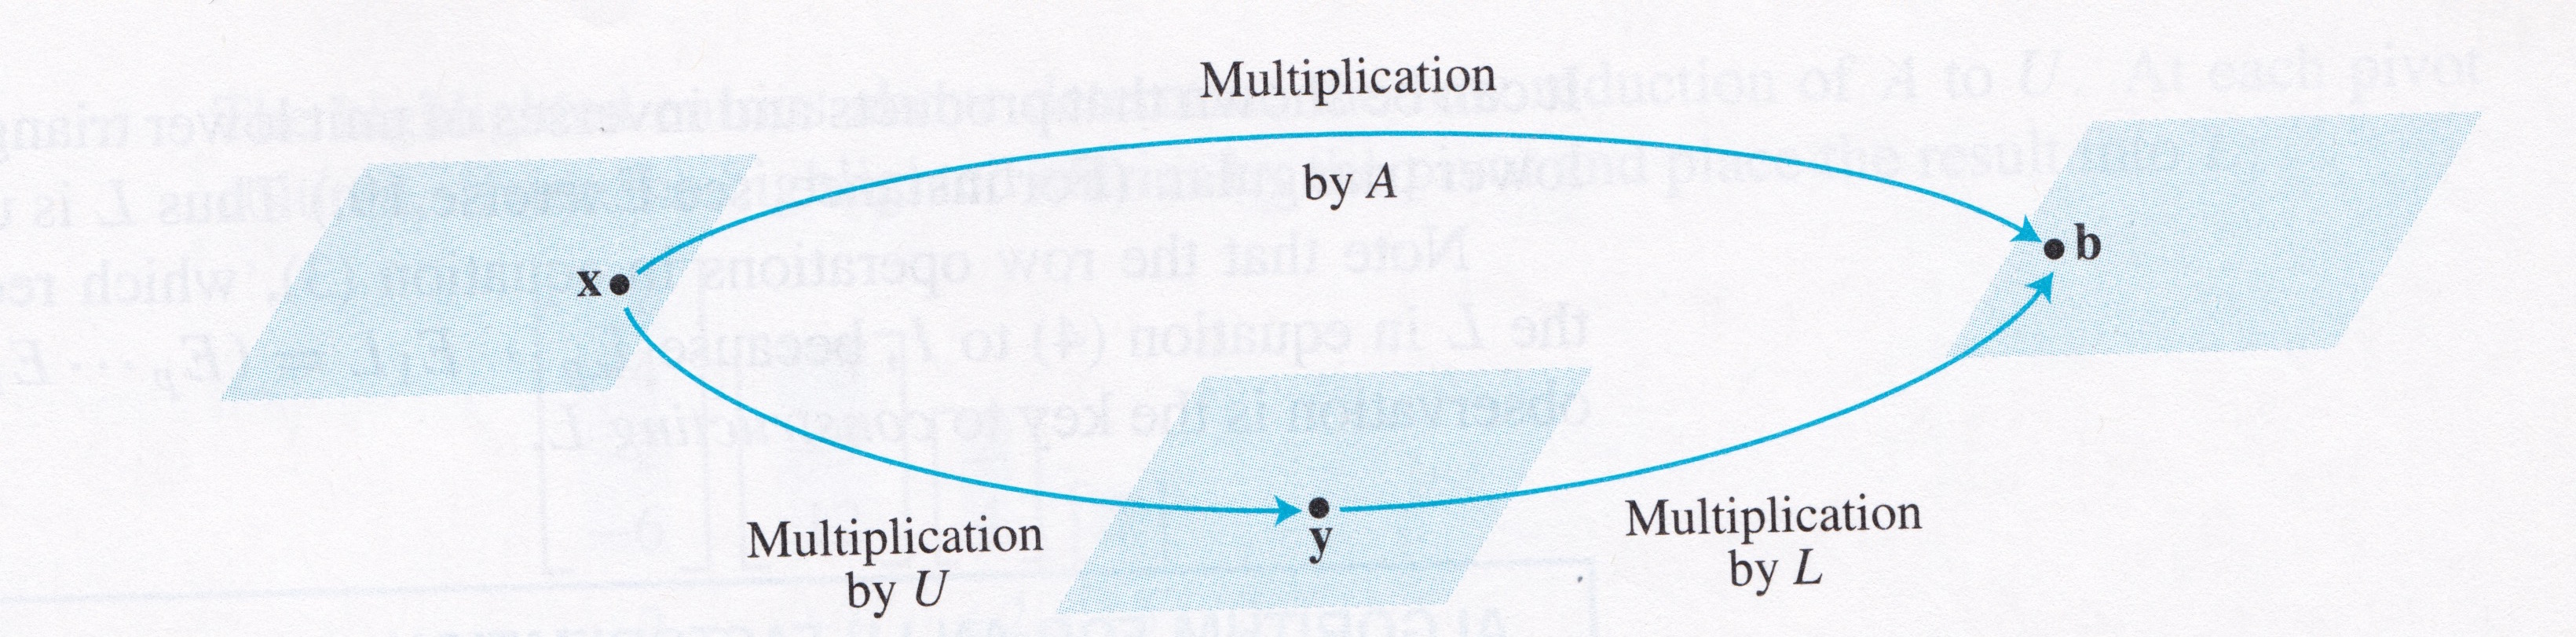

In [2]:
# image credit: Lay, 4th edition
display(Image("images/Lay-fig-2-5-2.jpeg", width=550))

The key observation: __each equation is fast to solve__ because $L$ and $U$ are each __triangular.__

__Example.__

Given the following LU decomposition of $A$:

$$A = \left[\begin{array}{rrrr}3&-7&-2&2\\-3&5&1&0\\6&-4&0&-5\\-9&5&-5&12\end{array}\right] = 
\left[\begin{array}{rrrr}1&0&0&0\\-1&1&0&0\\2&-5&1&0\\-3&8&3&1\end{array}\right]
\left[\begin{array}{rrrr}3&-7&-2&2\\0&-2&-1&2\\0&0&-1&1\\0&0&0&-1\end{array}\right] = LU$$

Use this LU factorization of $A$ to solve $A{\bf x} = {\bf b}$, where ${\bf b} = \left[\begin{array}{r}-9\\5\\7\\11\end{array}\right].$

__Solution.__  To solve $L{\bf y} = {\bf b},$ note that the arithmetic takes place only in the augmented column (column 5).   The zeros below each pivot in $L$ are created automatically by the choice of row operations.

$$[L\;\; {\bf b}] = \left[\begin{array}{rrrrr}1&0&0&0&-9\\-1&1&0&0&5\\2&-5&1&0&7\\-3&8&3&1&11\end{array}\right] \sim
\left[\begin{array}{rrrrr}1&0&0&0&-9\\0&1&0&0&-4\\0&0&1&0&5\\0&0&0&1&1\end{array}\right] = [I\;{\bf y}].$$

Next, for $U{\bf x} = {\bf y}$ (the "backward" phase) the row reduction is again streamlined:

$$[U\;\;{\bf y}] =  \left[\begin{array}{rrrrr}3&-7&-2&2&-9\\0&-2&-1&2&-4\\0&0&-1&1&5\\0&0&0&-1&1\end{array}\right] \sim
\left[\begin{array}{rrrrr}1&0&0&0&3\\0&1&0&0&4\\0&0&1&0&-6\\0&0&0&1&-1\end{array}\right].$$

__Operation Count Analysis.__

Both the forward and backward phases of solving a system as $L(U{\bf x}) = {\bf b}$ have flop counts of $\sim 2n^2$. 

Therefore to solve $A\mathbf{x} = \mathbf{b}$ using $LU\mathbf{x} = \mathbf{b}$, the dominating step is doing the factorization $A = LU$. 

We've seen that the factorization step is essentially Gaussian Elimination, and therefore requires $\sim\frac{2}{3}n^3$ flops.

Now, to return to our original problem.

To solve $$AX = B$$

where $A$ is $n\times n$, and both $X$ and $B$ have $p$ columns,

* By matrix inversion of $A$ requires $\sim 2n^3$ flops
* By LU factorization of $A$ requires $\sim \frac{2}{3}n^3 + 2p n^2$ flops

Hence we have found that by using the LU decomposition, one can solve a series of systems all involving the same $A$ in $\sim\frac{2}{3}n^3$ flops, 

while doing Gaussian Elimination would require $\sim\frac{2}{3}n^3$ flops __for each system__,

and using the matrix inverse would require $\sim2n^3$ flops to invert the matrix.

## Pivoting

Up until now we have assumed that the Gaussian Elimination we used to define $U$ only involves adding a multiple of a row to a row below it.

However, in real situations, we sometime need to exchange two rows.

One reason is, as we know, that if the current row has a zero in the pivot position, we need to exchange it with a row that does not have a zero in the pivot position.

But there is another, more subtle reason having to do with numerical accuracy.

We make the following observation: in general, we would like to avoid __dividing by a small number.__

Here is why.   Consider the problem of computing $a/b$ where $a$ and $b$ are scalars.   

Let's say there is some small error in the value of $a$, call it $\epsilon.$   

That means that what we are really computing is $(a+\epsilon)/b = a/b + \epsilon/b$. 

Note that $a/b$ is the correct value, but that what we compute is off by $\epsilon/b$.  Now, if $b$ is a very small number, then the error in the result ($\epsilon/b$) will be large.

Hence we would like to avoid dividing by small numbers whenever possible.  

Now: note that in performing Gaussian Elimination, we divide each row by the value of its pivot.

What this suggests is that we would like to avoid having small pivots.

There is a simple way to address this.   In processing any particular row, we can avoid having a small pivot by interchanging the current row with one of those below it.  

We would like to exchange the current row with the row that __has the largest absolute value of its pivot.__  This algorithmic technique is called "partial pivoting."

Now, a row interchange is an elementary row operation, and can be implemented by an elementary matrix.  This elementary matrix is the identity with its corresponding rows interchanged.   

An elementary matrix that exchanges rows is called a _permutation_ matrix.  The product of permutation matrices is a permutation matrix.  

Hence, the net result of all the partial pivoting done during Gaussian Elimination can be expressed in a single permutation matrix $P$.

This means that the final factorization of $A$ is:

$$A = P L U.$$

You can read this equation two ways:

1. $A$ is the product of a unit lower triangular matrix $L$ and an echelon form matrix $U$, and the rows of their product have been reordered according to the permulation $P$.  This is $A = P(LU).$
2. $A$ is the product of a _permuted_ lower triangular matrix $PL$ and an echelon form matrix $U$.  This is $A = (PL)U.$